# Mahalanobis matching , Schelling‘s Model of Segregation

Abu Ibne Bayazid (Imon)

## Mahalanobis matching
Another popular alternative to propensity score matching is "Mahalanobis matching". This is a greedy matching method, where each point of one group is matched to its nearest neighbor according to the Mahalanobis distance, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.mahalanobis.html for a formal definition. 



### Data preparation:
We apply Mahalanobis matching to the quality of government (QoG) data from the last home assignment. For this task, first load the QoG data into a pandas dataframe and select the columns "cname","wdi_lifexp" (life expectancy),"wdi_popden"(population density),"gle_cgdpc" (GDP per capita), "bti_ds" (Democracy Status).

Remove all countries with missing values. Then put all remaining countries into two groups:
* Full democratic (bti_ds > 8.0)
* Not full democratic (else)

In [37]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import mahalanobis
import scipy as sp
import pandas as pd
from scipy.stats import pearsonr

full_df = pd.read_csv("https://www.qogdata.pol.gu.se/data/qog_bas_cs_jan18.csv")
df = full_df[['cname','wdi_lifexp','wdi_popden','gle_cgdpc', 'bti_ds']]

df.dropna(inplace=True)

dem_df = df[df['bti_ds'] > 8.0]
ntdem_df = df[df['bti_ds'] <= 8.0]

print("Full Democratic")
print(dem_df.head())
print()
print("Not Full Democratic")
print(ntdem_df.head())

Full Democratic
         cname  wdi_lifexp  wdi_popden   gle_cgdpc  bti_ds
19    Botswana   64.694389    3.826466  12770.7300    8.25
20      Brazil   74.958244   24.432844   9815.2402    8.05
24    Bulgaria   74.465851   66.543274  13967.4500    8.15
35       Chile   78.964485   23.689362  15519.0800    9.15
42  Costa Rica   79.416855   93.176163   9485.7100    9.20

Not Full Democratic
         cname  wdi_lifexp  wdi_popden  gle_cgdpc    bti_ds
0  Afghanistan   62.902683   50.176178  1282.6400  3.016667
1      Albania   77.998390  105.441750  8516.7002  6.950000
2      Algeria   75.635025   16.422152  5402.1699  4.800000
4       Angola   60.806732   21.593380  3771.2000  4.250000
6   Azerbaijan   71.724754  115.348816  9793.3096  3.483333


C:\Users\imon_\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### a) Compute the Mahalanobis distance matrix with respect to the attribute population density and gdp per capita.

In [38]:
new_dem_df = dem_df.iloc[:,2:4]
new_ntdem_df = ntdem_df.iloc[:,2:4]

cov_dem_df = new_dem_df.cov().values
cov_ntdem_df = new_ntdem_df.cov().values

cov_dem_df = sp.linalg.inv(cov_dem_df)
cov_ntdem_df = sp.linalg.inv(cov_ntdem_df)

mean_dem = new_dem_df.mean().values
mean_ntdem = new_ntdem_df.mean().values

MD_dem_df = []
MD_ntdem_df = []

for i in range(new_dem_df.shape[0]):
    MD_dem_df.append(mahalanobis(new_dem_df.iloc[i,:],mean_dem,cov_dem_df) ** 2)

for j in range(new_ntdem_df.shape[0]):
    MD_ntdem_df.append(mahalanobis(new_ntdem_df.iloc[j,:],mean_ntdem,cov_ntdem_df) ** 2)

#Adding mahalanobis distance to the dataframe as last column namely MD
dem_df['MD'] = MD_dem_df
ntdem_df['MD'] = MD_ntdem_df

print("Full Democratic")
print(dem_df.head())
print()
print("Not Full Democratic")
print(ntdem_df.head())

Full Democratic
         cname  wdi_lifexp  wdi_popden   gle_cgdpc  bti_ds        MD
19    Botswana   64.694389    3.826466  12770.7300    8.25  0.767197
20      Brazil   74.958244   24.432844   9815.2402    8.05  1.255644
24    Bulgaria   74.465851   66.543274  13967.4500    8.15  0.262083
35       Chile   78.964485   23.689362  15519.0800    9.15  0.405422
42  Costa Rica   79.416855   93.176163   9485.7100    9.20  1.160547

Not Full Democratic
         cname  wdi_lifexp  wdi_popden  gle_cgdpc    bti_ds        MD
0  Afghanistan   62.902683   50.176178  1282.6400  3.016667  0.264456
1      Albania   77.998390  105.441750  8516.7002  6.950000  0.021075
2      Algeria   75.635025   16.422152  5402.1699  4.800000  0.071537
4       Angola   60.806732   21.593380  3771.2000  4.250000  0.120654
6   Azerbaijan   71.724754  115.348816  9793.3096  3.483333  0.044169


C:\Users\imon_\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\imon_\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### b) Matching:
Investigate if there is a statistical association between "Full Democratic" and "Not Full Democratic" on one hand and life expectancy on the other hand.
For that purpose, compute a full greedy matching according to the Mahalanobis distance w.r.t population density and gdp per capita. Determine for yourself a reasonable threshold when no a match should be discarded (i.e., there is no suitable match for a country in the other group). Compare the life expectancy in the two groups.

In [39]:
def greedy_matching (df_dem, df_ntdem, calliper):
    df_dem = df_dem.copy()
    df_ntdem = df_ntdem.copy()
    
    matching = {}
    for index_dem, values_dem in df_dem.iterrows():
        mahalan = values_dem['MD']
        df_ntdem ["diff_dist"] = np.abs(df_ntdem['MD'] - mahalan)
        if np.min(df_ntdem ['diff_dist']) < calliper:
            idxmin = df_ntdem['diff_dist'].idxmin()
            matching[index_dem] = idxmin
            df_ntdem.drop(idxmin, inplace=True)
    return matching

In [40]:
print("Before Matching")
print("Life Expectancy for Full Democratic")
print(dem_df['wdi_lifexp'].mean())
print("Life Expectancy for Not Full Democratic")
print(ntdem_df['wdi_lifexp'].mean())
print('\n')
mahalanobis_std = np.std(MD_ntdem_df + MD_dem_df)

#Various Thresholds for discarding a match
calliper_range = [ 0.01,0.02,0.2, 0.3,0.5]

print("After Matching...")
#Iterating through different calliper_range values
for i in calliper_range:
    calliper = i * mahalanobis_std
    matching = greedy_matching(dem_df, ntdem_df, calliper)
    df_matched_dem = dem_df.loc[matching.keys()]
    df_matched_ntdem = ntdem_df.loc [matching.values()]
    print("For calliper ",calliper,", item matched", len(matching))
    print ("Life Expectancy for Full Democratic",df_matched_dem['wdi_lifexp'].mean())
    print ("Life Expectancy for Not Full Democratic",df_matched_ntdem['wdi_lifexp'].mean())

    
    a=df_matched_dem['wdi_lifexp'].astype(int).ravel() 
    b=df_matched_ntdem['wdi_lifexp'].astype(int).ravel()
    corr, p_value = pearsonr(a,b)
    print('Pearson Correlation {}'.format(np.corrcoef(a,b)[0][1]))
    print('\n')


print('Analysing the above result, we can infer that life expectancy of people in full democratic countries is higher compared to the respective non democratic countries')    

Before Matching
Life Expectancy for Full Democratic
76.32902272542317
Life Expectancy for Not Full Democratic
68.42276553572896


After Matching...
For calliper  0.102761008704 , item matched 13
Life Expectancy for Full Democratic 75.53932248629056
Life Expectancy for Not Full Democratic 71.94059900137094
Pearson Correlation -0.08144589511133957


For calliper  0.205522017409 , item matched 14
Life Expectancy for Full Democratic 75.77396992274693
Life Expectancy for Not Full Democratic 71.85510335649762
Pearson Correlation -0.09368733807069457


For calliper  2.05522017409 , item matched 16
Life Expectancy for Full Democratic 76.09826040267944
Life Expectancy for Not Full Democratic 72.47446703910828
Pearson Correlation -0.006443020117742793


For calliper  3.08283026113 , item matched 16
Life Expectancy for Full Democratic 76.09826040267944
Life Expectancy for Not Full Democratic 72.47446703910828
Pearson Correlation -0.006443020117742793


For calliper  5.13805043522 , item matched 1

# Schelling‘s Model of Segregation

### a) Create grid
Write a function create_grid (shape, share_red, share_blue) that returns a numpy array of the given shape (rows, columns). Cells with a red agent should be marked with the value 1, cells with a blue agent with value 2, empty cells with a 0.

Naturally, share_red + share_blue < 1

In [41]:
from numpy import array
import random as ran
import numpy as np

def CreateGrid(shape, share_red , share_blue):    
    if(share_red+share_blue<1):
        share_empty=1-(share_red+share_blue)
        arr_random=np.random.choice([0,1,2],(shape,shape),p=[share_empty,share_red,share_blue])
    return arr_random

### b) Visualization

Write a function visualize(grid) that take a numpy array with these properties and plots it. We recommend to use matplotlib for this

[[1 1 2 2 2 1 2 2 1 1 2 0 1 1 2]
 [0 1 2 2 2 2 0 1 2 1 2 1 1 2 0]
 [2 1 2 1 2 2 0 1 0 2 2 1 2 0 1]
 [2 1 1 1 1 2 2 1 2 2 2 0 1 2 2]
 [1 2 1 1 1 1 1 1 1 1 2 2 1 2 2]
 [1 0 2 1 2 2 1 1 2 1 1 1 2 2 2]
 [1 1 2 2 0 1 0 2 1 2 1 2 2 2 2]
 [1 1 2 1 2 1 1 1 2 2 0 2 1 1 1]
 [2 1 1 1 2 2 2 1 1 2 1 2 1 0 2]
 [2 2 1 1 2 0 1 1 1 1 1 2 1 2 0]
 [2 2 1 1 2 1 2 2 2 1 1 2 2 1 1]
 [1 1 1 0 0 1 2 1 2 2 2 0 2 2 1]
 [2 1 2 1 2 1 1 2 2 2 2 1 0 1 2]
 [2 2 2 1 2 2 1 0 2 2 1 2 1 2 1]
 [2 1 2 2 1 1 1 2 2 1 2 1 2 2 2]]


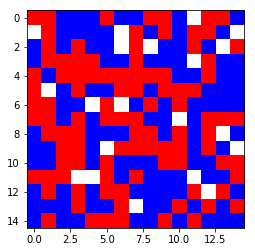

In [42]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def visualize(grid):
    
    mapcolor = mpl.colors.ListedColormap(['w','r','b'])
    mapcolor.set_over('2')
    mapcolor.set_under('0')

    plt.imshow(grid,cmap=mapcolor)   
    print(grid)
    plt.show()

    
grid=CreateGrid(15,0.45,0.45)
visualize(grid)

### c) Simulation Step

Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportion)

[[1 1 2 2 2 1 2 2 1 2 1 2 1 1 2]
 [1 2 2 2 2 2 1 2 2 2 2 1 1 1 1]
 [1 1 1 2 2 2 2 1 2 2 2 2 2 1 1]
 [2 1 1 1 1 2 2 1 2 2 2 2 1 2 2]
 [1 2 1 1 1 1 1 1 1 2 2 2 1 2 2]
 [1 1 2 1 1 1 1 1 2 1 1 2 2 2 2]
 [1 1 1 1 1 1 2 2 1 1 1 2 2 2 2]
 [1 1 2 1 1 1 1 1 0 2 2 2 2 1 1]
 [1 1 1 1 0 2 2 1 1 1 2 2 0 2 2]
 [2 0 1 1 1 2 0 1 1 1 1 2 2 2 0]
 [2 1 1 1 2 0 2 2 1 1 1 2 2 2 1]
 [1 1 1 1 1 0 2 0 2 2 2 2 2 2 1]
 [1 0 0 0 2 0 1 2 2 2 2 1 0 1 2]
 [2 2 2 1 2 1 1 0 2 2 1 2 0 2 0]
 [2 0 2 2 1 1 1 2 2 0 2 0 2 2 2]]


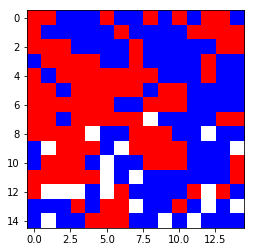

In [43]:
import random

#identifying the location of empty slots in grid
def empty_slots(grid):
    result = np.where(grid == 0)
    empty_list = list(zip(result[0], result[1]))
    return empty_list


#method to simulate movement of single agent to a empty slot when it doesn't meet PP
#written in a way to reuse the method for multiple steps agent movement
#returns a flag that indicates if the current agent has moved in the grid after the simulate
def simulate_single(grid, pp):
    
    empty_list = empty_slots(grid)
    changes_happened = False;
    for (i, j), value in np.ndenumerate(grid):
    
            current_agent = grid[i][j]
            same_counter = 0;
            diff_counter = 0;
            empty_agent = 0;
            
            #continue if the selected grid location is an empty slot
            if grid[i][j] == 0:
                continue;
            
            #conditions checking the surrounding vertices for a given agent - 8 at max, 3 near the edges.
            #inner if to check if the agent matches the neighbouring agent
            #inner else to check if the neighbouring agent is not an empty agent
            
            if i > 0 and j > 0:
                if grid[i-1][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i-1][j-1] != empty_agent:
                    diff_counter+=1;
                    
            if i > 0:
                if grid[i-1][j] == current_agent:
                    same_counter+=1;
                elif grid[i-1][j] != empty_agent:
                    diff_counter+=1;
            
            if j > 0:
                if grid[i][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i][j-1] != empty_agent:
                    diff_counter+=1;
                   
            if i < (grid.shape[0]-1) and j > 0:
                if grid[i+1][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i+1][j-1] != empty_agent:
                    diff_counter+=1;
                           
            if i < (grid.shape[0]-1):
                if grid[i+1][j] == current_agent:
                    same_counter+=1;
                elif grid[i+1][j] != empty_agent:
                    diff_counter+=1;
                    
            if i > 0 and j < (grid.shape[1]-1):
                if grid[(i-1,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i-1,j+1)] != empty_agent:
                    diff_counter += 1
                    
            if j < (grid.shape[1]-1):
                if grid[(i,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i,j+1)] != empty_agent:
                    diff_counter += 1
                    
            if i < (grid.shape[0]-1) and j < (grid.shape[1]-1):
                if grid[(i+1,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i+1,j+1)] != empty_agent:
                    diff_counter += 1            
            
            #happens if the agent is an empty agent
            if(same_counter+diff_counter == 0):
                continue;
            
            #compare the pp value against the obtained ratio
            elif(float(same_counter)/(same_counter+diff_counter) < pp):
                
                #picking an empty spot and replacing it with current agent
                #adding current agent location to empty slot
                rand = random.randint(0,(len(empty_list)-1))
                index = empty_list[rand]     
                grid[index[0]][index[1]] = grid[i][j]
                grid[i][j] = 0
                del empty_list[rand]
                empty_list.append((i,j))
                changes_happened = True;
                
    return changes_happened;

simulate_single(grid, 0.5)
visualize(grid)

### d) Full Simulation

Write a function simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization) that performs a full simulation of Schelling's model given a specific start state by performing steps until the maximum number of steps is reached or the was no change for the given amount of steps. Every iterations_to_next_vizualization steps, a visualization of the model should be plotted.


[[1 1 1 2 2 2 2 2 2 2 1 1 1 1 1]
 [1 1 0 2 2 2 2 2 2 2 0 1 1 1 1]
 [1 1 1 1 1 2 1 2 2 2 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 2 2 2 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 0 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 0 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 2 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [0 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


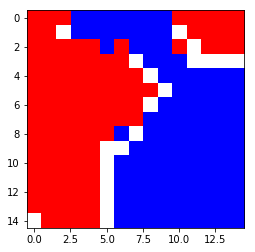

[[1 1 1 1 1 2 2 2 2 0 1 1 1 1 1]
 [1 1 1 1 2 0 2 2 2 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 0 0 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 2 2 0 1 0]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


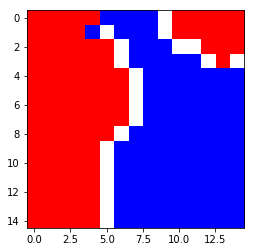

[[1 1 1 1 1 0 2 2 2 0 1 1 1 1 1]
 [1 1 1 1 1 0 2 2 2 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 2 1 0 0 0]
 [1 1 1 1 1 1 1 0 2 2 2 2 0 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


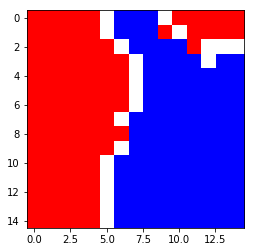

[[1 1 1 1 1 1 0 2 2 2 0 1 1 1 1]
 [1 1 1 1 1 1 1 2 2 2 0 0 1 1 1]
 [1 1 1 1 1 1 1 2 2 2 2 0 0 2 1]
 [1 1 1 1 1 1 0 2 2 2 2 2 0 2 2]
 [1 1 1 1 1 1 0 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


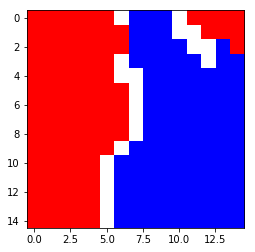

[[1 1 1 1 1 1 0 2 2 2 1 1 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 0 0 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 2 2 0 2 0]
 [1 1 1 1 1 1 0 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


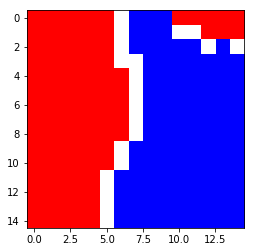

[[1 1 1 1 1 1 0 2 2 2 2 0 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 2 0 1 1 1]
 [1 1 1 1 1 1 2 2 2 2 2 2 0 0 0]
 [1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 1 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


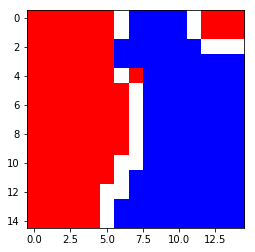

[[1 1 1 1 1 1 0 2 2 2 2 0 1 1 1]
 [1 1 1 1 1 1 1 2 2 2 2 0 1 1 1]
 [1 1 1 1 1 1 0 2 2 2 2 2 0 0 0]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 0 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 0 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 0 2 2 2 2 2 2 2 2 2]]


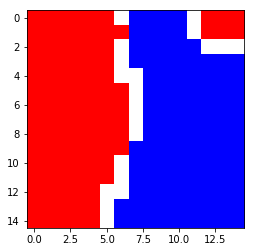

Maximum no change steps reached


In [44]:
#method to simulate number of given steps, or till there is no changes for specified number of steps
def simulate(grid, preferred_proportion, max_steps, no_changes_steps, iterations_to_next_vizualization):
    no_changes_count = 0;
    for i in range(max_steps):
        
        #counter update - to check if there is any changes made after the simulate
        if(simulate_single(grid, preferred_proportion)==False):
            no_changes_count+=1
        else:
            no_changes_count=0
    
        #to see if there is no changes happening for a specified number of steps
        if(no_changes_count == no_changes_steps):
            print("Maximum no change steps reached")
            break;
            
        #to generate a grid visualization after specified number of iterations
        if((i+1)%iterations_to_next_vizualization == 0):
            visualize(grid)
            
simulate(grid, 0.7, 150, 5, 10)

### e) Model Extension

Edit your functions such that they support multiple groups (instead of just red and blue), and each group can have a separate preferred proportion. Use for this the following signatures

create_grid (shape, shares): percentages should be a list of shares for each color
visualize(grid) => choose appropriate colors
Simulate a single step (potential movement of a single randomly picked agent) of the Schelling model with a function simulate(grid, preferred_proportions) => Gives a list of preferred proportions for each color.


[[0 0 1 1 3 0 0 0 0 1 0 0 1 1 0 1 3 0 1 2]
 [1 1 0 0 1 2 0 2 0 2 0 0 0 0 0 2 1 0 1 1]
 [3 1 0 1 0 0 2 3 1 1 0 2 2 1 1 0 1 0 0 0]
 [2 1 0 0 0 2 1 1 0 2 1 2 0 3 0 0 1 3 2 3]
 [1 1 3 3 0 1 1 1 0 1 2 0 1 0 0 1 2 1 0 1]
 [2 2 3 1 0 0 3 0 0 3 1 0 3 0 0 2 1 3 0 3]
 [3 0 1 2 2 1 2 3 3 0 1 0 1 0 1 2 0 0 2 1]
 [3 1 1 1 2 0 2 1 0 2 3 0 1 0 2 1 0 0 2 0]
 [2 3 1 0 0 2 3 3 0 0 1 0 0 0 2 1 0 1 1 3]
 [1 1 0 2 0 0 0 2 3 3 0 0 2 0 1 1 0 1 2 2]
 [1 1 0 0 1 3 2 0 2 2 0 1 0 0 0 0 0 3 0 0]
 [3 2 2 2 0 0 0 0 3 0 0 0 0 0 1 0 0 0 1 2]
 [0 1 2 2 0 0 1 0 2 2 1 2 1 1 1 3 0 0 0 0]
 [1 0 2 3 2 0 1 0 3 2 0 1 2 2 1 0 2 3 2 2]
 [0 2 0 2 1 0 1 2 2 2 2 0 2 2 1 0 0 3 1 0]
 [3 2 0 1 1 2 1 0 2 2 1 0 0 3 1 0 0 1 2 1]
 [0 0 3 1 3 1 1 2 0 3 0 0 0 2 3 0 1 3 0 1]
 [0 0 2 1 1 0 1 1 1 3 1 0 1 1 1 2 0 2 0 0]
 [3 1 0 0 2 1 0 1 1 2 0 0 2 2 2 3 0 0 1 1]
 [2 2 3 1 2 1 1 3 0 1 0 0 0 2 0 1 0 2 2 1]]


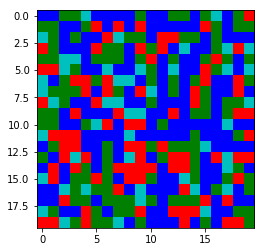

[[2 1 2 2 2 0 0 0 1 1 0 0 1 1 0 0 1 1 2 1]
 [1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 2 2 0 2 1]
 [1 1 0 2 0 0 1 2 0 2 0 2 1 1 1 0 2 0 0 0]
 [2 1 0 0 0 2 1 1 0 1 1 1 0 1 0 0 2 2 1 1]
 [1 2 1 1 0 1 1 2 0 1 2 0 1 0 0 2 0 1 0 1]
 [2 2 2 2 0 0 2 0 0 1 1 0 1 0 0 1 1 1 0 1]
 [2 2 2 2 1 1 2 1 0 0 1 0 2 0 0 2 0 0 1 1]
 [1 1 0 2 1 0 2 1 0 2 1 0 2 0 2 2 0 0 2 0]
 [1 2 2 0 0 1 2 1 0 0 1 0 0 0 1 1 0 0 2 0]
 [1 2 0 2 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0]
 [1 2 0 0 0 2 1 0 1 1 0 2 0 0 0 0 0 1 0 2]
 [0 1 2 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 2 2 0 0 0 0 2 0 2 1 1 2 1 2 0 0 0 1]
 [1 0 2 1 1 0 1 0 0 2 0 1 2 2 2 0 0 2 1 0]
 [1 0 0 1 0 0 0 1 2 2 2 1 2 2 0 0 0 0 0 0]
 [0 1 0 1 1 1 1 0 2 2 0 0 0 2 1 0 0 0 0 1]
 [0 0 1 0 1 0 0 0 1 2 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 2 0 0 2 2 2 2 0 0 0 1]
 [2 2 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0 2 2 0]]


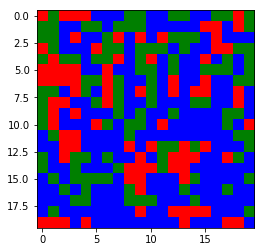

In [45]:
#method to create grid with more than two segregations
def create_grid_multiple(shape, shares):
    share_empty=1-sum(shares)
    shares.append(share_empty)
    grid=np.random.choice(range(0, len(shares)),(shape,shape),p=shares)
    return grid

#method to visualize grid with multiple agents
def visualize_multiple(grid):    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'];
    mapcolor = mpl.colors.ListedColormap(colors[:len(np.unique(grid))])
    plt.imshow(grid,cmap=mapcolor)   
    print(grid)
    plt.show()

#method to identify the empty slots in the grid
def empty_slots_multiple(grid):
    result = np.where(grid == np.unique(grid)[-1])
    empty_list = list(zip(result[0], result[1]))
    return empty_list
    
#method to simulate movement of a single step in a grid with multiple agents
def simulate(grid, preferred_proportions):
    
    empty_list = empty_slots_multiple(grid)
    changes_happened = False;

    for (i, j), value in np.ndenumerate(grid):
    
            current_agent = grid[i][j]
            same_counter = 0;
            diff_counter = 0;
            empty_agent = np.unique(grid)[-1];
                        
            if grid[i][j] == empty_agent:
                continue;
            
            if i > 0 and j > 0:
                if grid[i-1][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i-1][j-1] != empty_agent:
                    diff_counter+=1;
                    
            if i > 0:
                if grid[i-1][j] == current_agent:
                    same_counter+=1;
                elif grid[i-1][j] != empty_agent:
                    diff_counter+=1;
            
            if j > 0:
                if grid[i][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i][j-1] != empty_agent:
                    diff_counter+=1;
                   
            if i < (grid.shape[0]-1) and j > 0:
                if grid[i+1][j-1] == current_agent:
                    same_counter+=1;
                elif grid[i+1][j-1] != empty_agent:
                    diff_counter+=1;
                           
            if i < (grid.shape[0]-1):
                if grid[i+1][j] == current_agent:
                    same_counter+=1;
                elif grid[i+1][j] != empty_agent:
                    diff_counter+=1;
                    
            if i > 0 and j < (grid.shape[1]-1):
                if grid[(i-1,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i-1,j+1)] != empty_agent:
                    diff_counter += 1
                    
            if j < (grid.shape[1]-1):
                if grid[(i,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i,j+1)] != empty_agent:
                    diff_counter += 1
                    
            if i < (grid.shape[0]-1) and j < (grid.shape[1]-1):
                if grid[(i+1,j+1)] == current_agent:
                    same_counter += 1
                elif grid[(i+1,j+1)] != empty_agent:
                    diff_counter += 1        

            #checking the calculated value against the pp value of a specific agent passed as parameter
            if(float(same_counter)/(same_counter+diff_counter) < preferred_proportions[current_agent]):
                
                rand = random.randint(0,(len(empty_list)-1))
                index = empty_list[rand]
                
                grid[index[0]][index[1]] = grid[i][j]
                grid[i][j] = 0
                del empty_list[rand]
                empty_list.append((i,j))
    
    
grid=create_grid_multiple(20, [0.4,0.3,0.2])
visualize_multiple(grid)
simulate(grid,[0.5, 0.6, 0.3])
visualize_multiple(grid)